# 01. 탐색적 데이터 분석 (EDA)

IBM HR Analytics 데이터셋의 전반적인 특성을 파악하고, 퇴사(Attrition) 여부에 따른 차이를 분석한다.

In [ ]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from src.data_loader import load_raw_data

# 시각화 기본 설정
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style='whitegrid', font='Apple SD Gothic Neo')

# 색상 팔레트
COLORS = {'Yes': '#E74C3C', 'No': '#3498DB'}
PALETTE = [COLORS['No'], COLORS['Yes']]

%matplotlib inline

## 1.1 데이터 로드 및 기본 정보

In [ ]:
df = load_raw_data()

print(f"데이터 크기: {df.shape[0]}행 × {df.shape[1]}열")
print(f"\n결측치 수: {df.isnull().sum().sum()}")
print(f"중복 행 수: {df.duplicated().sum()}")
df.info()

In [ ]:
# 분석에 불필요한 상수/ID 컬럼 확인
const_cols = [col for col in df.columns if df[col].nunique() <= 1]
id_cols = ['EmployeeNumber']
drop_cols = const_cols + id_cols

print(f"상수 컬럼 (분산=0): {const_cols}")
print(f"ID 컬럼: {id_cols}")
print(f"→ 제거 대상: {drop_cols}")

df = df.drop(columns=drop_cols)
print(f"\n제거 후 데이터 크기: {df.shape[0]}행 × {df.shape[1]}열")

## 1.2 기초 통계량

In [ ]:
# 수치형 변수 기초 통계
num_cols = df.select_dtypes(include='number').columns.tolist()
df[num_cols].describe().round(2)

In [ ]:
# 범주형 변수 기초 통계
cat_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()
for col in cat_cols:
    print(f"[{col}] ({df[col].nunique()}개 값)")
    print(df[col].value_counts())
    print()

## 1.3 타겟 변수 분포 (Attrition)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 퇴사 비율 (파이)
counts = df['Attrition'].value_counts()
axes[0].pie(counts, labels=['재직 (No)', '퇴사 (Yes)'], autopct='%1.1f%%',
            colors=PALETTE, startangle=90, textprops={'fontsize': 13})
axes[0].set_title('퇴사 여부 비율', fontsize=15, fontweight='bold')

# 퇴사 건수 (막대)
sns.countplot(data=df, x='Attrition', palette=COLORS, ax=axes[1], order=['No', 'Yes'])
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}명',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=13)
axes[1].set_title('퇴사 여부 건수', fontsize=15, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('인원 수')

plt.tight_layout()
plt.savefig('../outputs/figures/01_attrition_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"퇴사율: {(df['Attrition']=='Yes').mean():.1%} ({counts['Yes']}명 / {len(df)}명)")
print(f"불균형 비율: 1:{counts['No']/counts['Yes']:.1f}")

## 1.4 수치형 변수 분포

In [ ]:
# 주요 연속형 변수 히스토그램 (퇴사 여부별)
key_num_cols = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany',
                'YearsInCurrentRole', 'YearsWithCurrManager', 'DistanceFromHome',
                'NumCompaniesWorked']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(key_num_cols):
    sns.histplot(data=df, x=col, hue='Attrition', kde=True,
                 palette=COLORS, alpha=0.5, ax=axes[i])
    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')

plt.suptitle('주요 수치형 변수 분포 (퇴사 여부별)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/02_numeric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# 수치형 변수 — 퇴사 여부별 박스플롯
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(key_num_cols):
    sns.boxplot(data=df, x='Attrition', y=col, palette=COLORS, ax=axes[i], order=['No', 'Yes'])
    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')

plt.suptitle('퇴사 여부별 수치형 변수 비교 (Box Plot)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/03_numeric_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()

## 1.5 범주형 변수 분포

In [ ]:
# 범주형 변수별 퇴사율
cat_features = ['OverTime', 'MaritalStatus', 'JobRole', 'Department',
                'BusinessTravel', 'Gender', 'EducationField']

fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    rates = df.groupby(col)['Attrition'].apply(lambda x: (x == 'Yes').mean()).sort_values(ascending=True)
    colors = ['#E74C3C' if r > 0.20 else '#F39C12' if r > 0.15 else '#3498DB' for r in rates]
    rates.plot(kind='barh', ax=axes[i], color=colors)
    axes[i].set_title(f'{col}별 퇴사율', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('퇴사율')
    axes[i].axvline(x=df['Attrition'].apply(lambda x: x == 'Yes').mean(),
                    color='gray', linestyle='--', alpha=0.7, label='전체 평균')
    for j, (val, rate) in enumerate(rates.items()):
        axes[i].text(rate + 0.005, j, f'{rate:.1%}', va='center', fontsize=9)

axes[-1].set_visible(False)

plt.suptitle('범주형 변수별 퇴사율 (점선: 전체 평균 16.1%)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/04_categorical_attrition_rates.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# 순서형 변수별 퇴사율 (만족도, 몰입도 등)
ordinal_cols = ['EnvironmentSatisfaction', 'JobSatisfaction',
                'RelationshipSatisfaction', 'WorkLifeBalance',
                'JobInvolvement', 'JobLevel', 'StockOptionLevel', 'Education']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(ordinal_cols):
    rates = df.groupby(col)['Attrition'].apply(lambda x: (x == 'Yes').mean())
    cnts = df.groupby(col).size()

    ax2 = axes[i].twinx()
    axes[i].bar(rates.index, cnts, color='#BDC3C7', alpha=0.5, label='인원 수')
    ax2.plot(rates.index, rates.values, 'o-', color='#E74C3C', linewidth=2, markersize=8, label='퇴사율')
    ax2.axhline(y=0.161, color='gray', linestyle='--', alpha=0.5)
    ax2.set_ylim(0, max(rates.values) * 1.5)

    axes[i].set_title(col, fontsize=10, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('인원 수', fontsize=9)
    ax2.set_ylabel('퇴사율', fontsize=9)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.suptitle('순서형 변수별 인원 수 & 퇴사율', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/05_ordinal_attrition_rates.png', dpi=150, bbox_inches='tight')
plt.show()

## 1.6 상관관계 분석

In [ ]:
# 수치형 변수 상관관계 히트맵
corr = df[num_cols].corr()

fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 7})
ax.set_title('수치형 변수 상관관계 히트맵', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/figures/06_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# 높은 상관관계 쌍 출력 (|r| > 0.5)
print("높은 상관관계 쌍 (|r| > 0.5):")
for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        r = corr.iloc[i, j]
        if abs(r) > 0.5:
            print(f"  {corr.columns[i]:25s} × {corr.columns[j]:25s}  r = {r:+.3f}")

## 1.7 퇴사 여부별 주요 변수 비교 (통계 검정)

단순 시각화를 넘어서 통계적으로 유의한 차이가 있는지 검정한다.
- **수치형**: 독립표본 t-test + Cohen's d (효과 크기)
- **범주형**: 카이제곱 검정 + Cramér's V
- **순서형**: Mann-Whitney U 검정 + rank-biserial r

In [ ]:
yes = df[df['Attrition'] == 'Yes']
no = df[df['Attrition'] == 'No']

# --- 수치형 변수 t-test ---
print("=" * 80)
print("수치형 변수 — 독립표본 t-test")
print("=" * 80)

ttest_results = []
continuous_cols = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany',
                   'YearsInCurrentRole', 'YearsWithCurrManager', 'YearsSinceLastPromotion',
                   'DistanceFromHome', 'NumCompaniesWorked', 'PercentSalaryHike',
                   'TrainingTimesLastYear', 'DailyRate', 'HourlyRate', 'MonthlyRate']

for col in continuous_cols:
    t_stat, p_val = stats.ttest_ind(yes[col], no[col])
    pooled_std = np.sqrt((yes[col].std()**2 + no[col].std()**2) / 2)
    cohen_d = (yes[col].mean() - no[col].mean()) / pooled_std
    sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
    ttest_results.append({
        '변수': col, '퇴사 평균': yes[col].mean(), '재직 평균': no[col].mean(),
        "Cohen's d": cohen_d, 'p-value': p_val, '유의성': sig
    })

ttest_df = pd.DataFrame(ttest_results).sort_values("Cohen's d", key=abs, ascending=False)
ttest_df

In [ ]:
# --- 범주형 변수 카이제곱 검정 ---
print("=" * 80)
print("범주형 변수 — 카이제곱 검정")
print("=" * 80)

chi2_results = []
cat_test_cols = ['OverTime', 'MaritalStatus', 'BusinessTravel', 'Department',
                 'JobRole', 'Gender', 'EducationField']

for col in cat_test_cols:
    ct = pd.crosstab(df[col], df['Attrition'])
    chi2, p_val, dof, _ = stats.chi2_contingency(ct)
    cramers_v = np.sqrt(chi2 / (len(df) * (min(ct.shape) - 1)))
    sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
    chi2_results.append({
        '변수': col, 'Chi-square': chi2, "Cramér's V": cramers_v,
        'p-value': p_val, '유의성': sig
    })

chi2_df = pd.DataFrame(chi2_results).sort_values("Cramér's V", ascending=False)
chi2_df

In [ ]:
# --- 순서형 변수 Mann-Whitney U 검정 ---
print("=" * 80)
print("순서형 변수 — Mann-Whitney U 검정 (비모수)")
print("=" * 80)

mw_results = []
ordinal_test_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction',
                     'WorkLifeBalance', 'JobInvolvement', 'JobLevel', 'StockOptionLevel',
                     'Education', 'PerformanceRating']

for col in ordinal_test_cols:
    u_stat, p_val = stats.mannwhitneyu(yes[col], no[col], alternative='two-sided')
    n1, n2 = len(yes), len(no)
    r = 1 - (2 * u_stat) / (n1 * n2)
    sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
    mw_results.append({
        '변수': col, '퇴사 중앙값': yes[col].median(), '재직 중앙값': no[col].median(),
        'rank-biserial r': r, 'p-value': p_val, '유의성': sig
    })

mw_df = pd.DataFrame(mw_results).sort_values('rank-biserial r', key=abs, ascending=False)
mw_df

In [ ]:
# --- 야근(OverTime) × 퇴사: 오즈비 분석 ---
print("=" * 80)
print("야근 × 퇴사 교차분석 & 오즈비")
print("=" * 80)

ct = pd.crosstab(df['OverTime'], df['Attrition'], margins=True)
print(ct)
print()

a = ct.loc['Yes', 'Yes']
b = ct.loc['Yes', 'No']
c = ct.loc['No', 'Yes']
d = ct.loc['No', 'No']

odds_ratio = (a * d) / (b * c)
se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
ci_low = np.exp(np.log(odds_ratio) - 1.96 * se_log_or)
ci_high = np.exp(np.log(odds_ratio) + 1.96 * se_log_or)

print(f"야근 O 퇴사율: {a/(a+b):.1%}")
print(f"야근 X 퇴사율: {c/(c+d):.1%}")
print(f"\nOdds Ratio = {odds_ratio:.2f} (95% CI: {ci_low:.2f} ~ {ci_high:.2f})")
print("→ 야근하는 직원은 안 하는 직원 대비 퇴사 오즈가 약 3.8배 높다")

findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: Font family 'Apple SD Gothic Neo' not found.
findfont: 

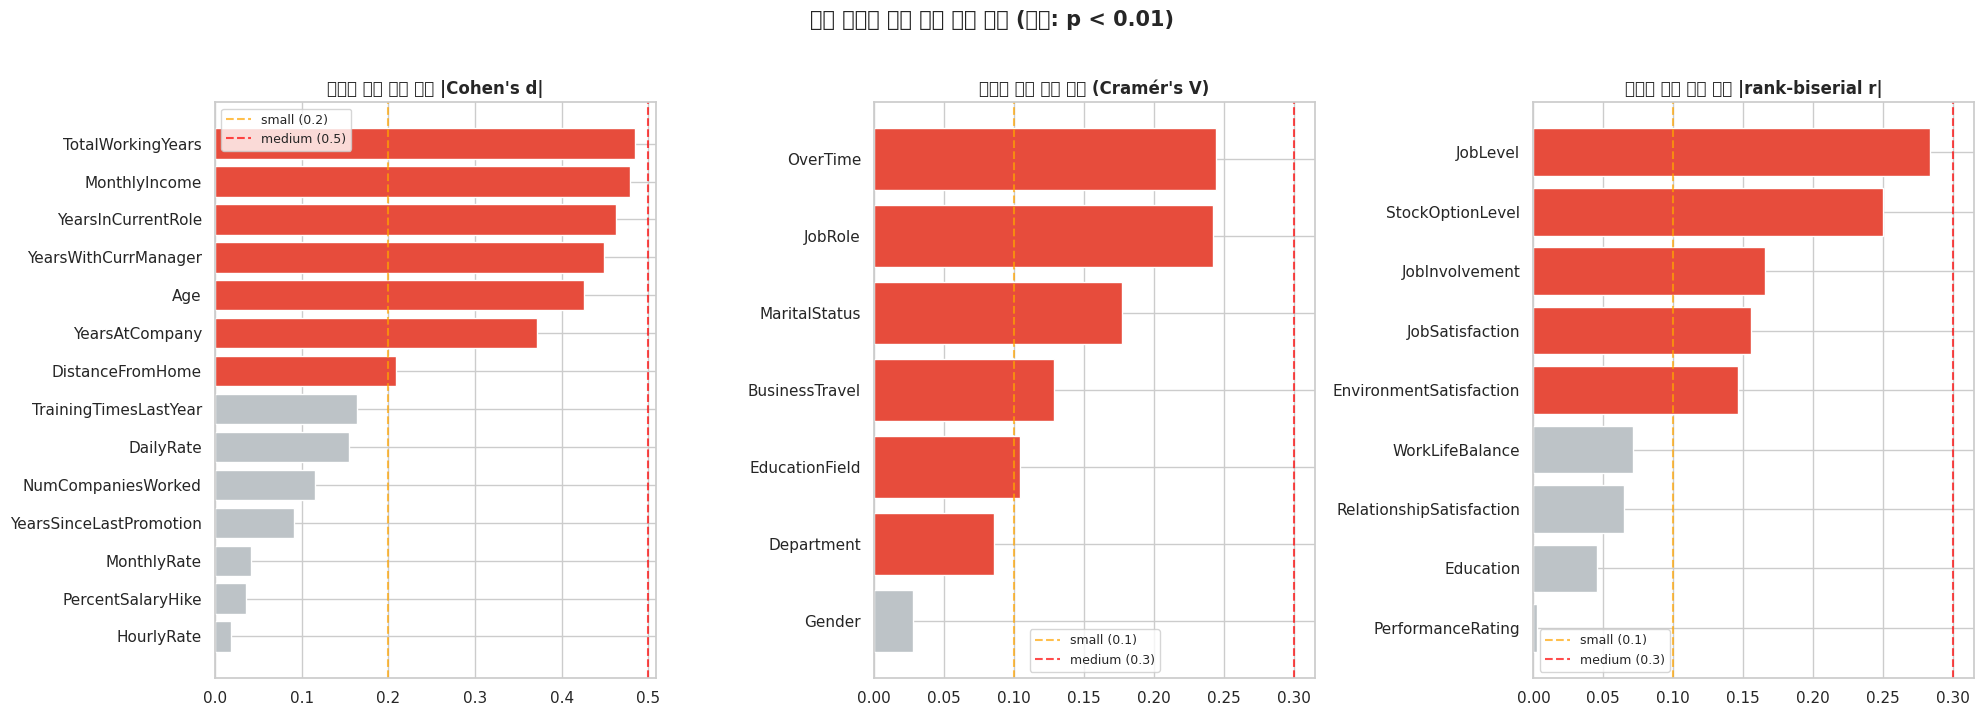

In [16]:
# --- 통계 검정 결과를 시각화로 정리 ---
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# 1) 수치형 — Cohen's d 효과 크기
ttest_sorted = ttest_df.sort_values("Cohen's d", key=abs, ascending=True)
colors_t = ['#E74C3C' if s in ['***', '**'] else '#BDC3C7' for s in ttest_sorted['유의성']]
axes[0].barh(ttest_sorted['변수'], ttest_sorted["Cohen's d"].abs(), color=colors_t)
axes[0].axvline(x=0.2, color='orange', linestyle='--', alpha=0.7, label='small (0.2)')
axes[0].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='medium (0.5)')
axes[0].set_title("수치형 변수 효과 크기 |Cohen's d|", fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)

# 2) 범주형 — Cramér's V
chi2_sorted = chi2_df.sort_values("Cramér's V", ascending=True)
colors_c = ['#E74C3C' if s in ['***', '**'] else '#BDC3C7' for s in chi2_sorted['유의성']]
axes[1].barh(chi2_sorted['변수'], chi2_sorted["Cramér's V"], color=colors_c)
axes[1].axvline(x=0.1, color='orange', linestyle='--', alpha=0.7, label='small (0.1)')
axes[1].axvline(x=0.3, color='red', linestyle='--', alpha=0.7, label='medium (0.3)')
axes[1].set_title("범주형 변수 연관 강도 (Cramér's V)", fontsize=12, fontweight='bold')
axes[1].legend(fontsize=9)

# 3) 순서형 — rank-biserial r
mw_sorted = mw_df.sort_values('rank-biserial r', key=abs, ascending=True)
colors_m = ['#E74C3C' if s in ['***', '**'] else '#BDC3C7' for s in mw_sorted['유의성']]
axes[2].barh(mw_sorted['변수'], mw_sorted['rank-biserial r'].abs(), color=colors_m)
axes[2].axvline(x=0.1, color='orange', linestyle='--', alpha=0.7, label='small (0.1)')
axes[2].axvline(x=0.3, color='red', linestyle='--', alpha=0.7, label='medium (0.3)')
axes[2].set_title("순서형 변수 효과 크기 |rank-biserial r|", fontsize=12, fontweight='bold')
axes[2].legend(fontsize=9)

plt.suptitle('퇴사 여부별 통계 검정 결과 요약 (빨강: p < 0.01)', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/07_statistical_tests_summary.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# --- 고위험 세그먼트 조합 분석 ---
print("=" * 80)
print("고위험 세그먼트 조합 분석")
print("=" * 80)
print(f"{'세그먼트':<35s} {'인원':>5s} {'퇴사':>5s} {'퇴사율':>7s}")
print("-" * 55)

segments = [
    ("전체 평균", pd.Series([True] * len(df))),
    ("야근 O", df['OverTime'] == 'Yes'),
    ("미혼 (Single)", df['MaritalStatus'] == 'Single'),
    ("야근O + 미혼", (df['OverTime'] == 'Yes') & (df['MaritalStatus'] == 'Single')),
    ("야근O + 미혼 + Level 1", (df['OverTime'] == 'Yes') & (df['MaritalStatus'] == 'Single') & (df['JobLevel'] == 1)),
    ("야근O + 스톡옵션 없음", (df['OverTime'] == 'Yes') & (df['StockOptionLevel'] == 0)),
    ("야근O + 만족도 낮음(1~2)", (df['OverTime'] == 'Yes') & (df['JobSatisfaction'] <= 2)),
    ("저소득(<3K) + 신입(≤2년)", (df['MonthlyIncome'] < 3000) & (df['YearsAtCompany'] <= 2)),
    ("Lab Tech + 야근O", (df['JobRole'] == 'Laboratory Technician') & (df['OverTime'] == 'Yes')),
    ("Sales Rep 전체", df['JobRole'] == 'Sales Representative'),
]

for name, mask in segments:
    sub = df[mask]
    n_yes = (sub['Attrition'] == 'Yes').sum()
    rate = n_yes / len(sub) if len(sub) > 0 else 0
    marker = " ◀◀◀" if rate > 0.40 else " ◀" if rate > 0.25 else ""
    print(f"{name:<35s} {len(sub):5d} {n_yes:5d} {rate:7.1%}{marker}")

고위험 세그먼트 조합 분석
세그먼트                                   인원    퇴사     퇴사율
-------------------------------------------------------
전체 평균                                1470   237   16.1%
야근 O                                  416   127   30.5% ◀
미혼 (Single)                           470   120   25.5% ◀
야근O + 미혼                              131    65   49.6% ◀◀◀
야근O + 미혼 + Level 1                     59    40   67.8% ◀◀◀
야근O + 스톡옵션 없음                         182    82   45.1% ◀◀◀
야근O + 만족도 낮음(1~2)                     153    56   36.6% ◀
저소득(<3K) + 신입(≤2년)                    181    69   38.1% ◀
Lab Tech + 야근O                         62    31   50.0% ◀◀◀
Sales Rep 전체                           83    33   39.8% ◀


## 1.8 EDA 요약 및 시사점

### 데이터 개요
- 1,470명 × 31개 변수 (상수/ID 4개 제거 후)
- **결측치 없음**, 중복 행 없음
- 타겟 불균형: 퇴사 237명(16.1%) vs 재직 1,233명(83.9%) → 모델링 시 불균형 처리 필수

### 퇴사와 강한 연관이 확인된 변수

| 유형 | 변수 | 검정 | 효과 크기 | 핵심 발견 |
|------|------|------|----------|----------|
| 범주형 | **OverTime** | Chi² *** | V=0.244 | 야근자 퇴사율 30.5% vs 비야근 10.4%, OR=3.77 |
| 범주형 | **JobRole** | Chi² *** | V=0.242 | Sales Rep 39.8%, Lab Tech 23.9% |
| 범주형 | **MaritalStatus** | Chi² *** | V=0.177 | 미혼 25.5% vs 기혼 12.5% |
| 수치형 | **TotalWorkingYears** | t *** | d=-0.484 | 퇴사자 평균 8.2년 vs 재직 11.9년 |
| 수치형 | **MonthlyIncome** | t *** | d=-0.479 | 퇴사자 $4,787 vs 재직 $6,833 |
| 수치형 | **YearsInCurrentRole** | t *** | d=-0.462 | 퇴사자 2.9년 vs 재직 4.5년 |
| 순서형 | **JobLevel** | MW *** | r=0.283 | Level 1 퇴사율 26.3% |
| 순서형 | **StockOptionLevel** | MW *** | r=0.250 | 스톡옵션 없음 24.4% vs 있음 9.9% |

### 퇴사와 무관한 변수 (편견 반박)
- **Gender** (p=0.291): 성별에 따른 퇴사 차이 없음
- **PerformanceRating** (p=0.912): 성과가 낮아서 퇴사하는 것이 아님
- **PercentSalaryHike** (p=0.606): 연봉 인상률은 퇴사와 무관
- **HourlyRate** (p=0.793): 시급 자체보다 총소득(MonthlyIncome)이 중요

### 다중공선성 주의 (모델링 시 처리 필요)
- MonthlyIncome ↔ JobLevel (r=0.95): 사실상 동일 정보
- Years 계열 변수들 간 r > 0.6~0.8: 근속 관련 변수 축소 고려

### 고위험 세그먼트 (개입 우선순위)
1. **야근O + 미혼 + Level 1**: 퇴사율 67.8% (59명 중 40명)
2. **Lab Tech + 야근O**: 퇴사율 50.0%
3. **야근O + 스톡옵션 없음**: 퇴사율 45.1%

### 전처리 단계에서 할 일
1. Attrition → 이진 변환 (Yes=1, No=0)
2. 범주형 인코딩 (One-Hot or Label)
3. 수치형 스케일링 (특히 LR용)
4. 다중공선성 높은 변수 제거 또는 PCA 검토
5. 클래스 불균형 처리 전략 결정